# **Willkommen zur interaktiven Vorlesung zum Thema "Budyko und die klimatische Wasserbilanz"**

<div>
    <img src="figures/uni_potsdam.jpg" alt="Figure 1" style="width: 5%; display: inline-block;"/>
    <img src="figures/uni_freiburg.png" alt="Figure 2" style="width: 5%; display: inline-block;"/>
</div>

**Sebastian Gnann, Daniel Kretschmer, Thorsten Wagener**


Bei Fragen und Feedback wenden Sie sich bitte an: sebastian.gnann@hydrologie.uni-freiburg.de oder thorsten.wagener@uni-potsdam.de

---

Die Online-Vorlesung basiert auf einem sogenannten Jupyter Notebook (https://jupyter.org/). 
Ein Notebook besteht aus einzelnen Zellen, die entweder Markdown-Text oder Python-Code beinhalten.
In dieser Vorlesung sollen Sie sich durch das Notebook arbeiten und interaktiv mit echten Daten an das Thema herangeführt werden.

In dieser Online-Vorlesung geht es um Budyko und die klimatische Wasserbilanz. Wir setzen gewisse Grundlagen der Hydrologie voraus. Sie sollten beispielsweise wissen, was Hydrologie ist, die wichtigsten hydrologischen Variablen kennen und schon mal von der Wasserbilanz und dem Wasserkreislauf gehört haben. Eine kurze Einführung gibt es ansonsten auch auf Wikipedia (https://de.wikipedia.org/wiki/Hydrologie) oder in verschiedenen Sachbüchern (z.B. https://www.utb.de/doi/book/10.36198/9783838545134).


## Struktur der Vorlesung

I. Jupyter Notebooks: eine kurze Einführung

II. Budyko and die klimatische Wasserbilanz

III. Lösungsvorschläge und zusätzliche Informationen


# **I. Jupyter Notebooks: eine kurze Einführung**

### **Informationen zu Jupyter Notebooks**

Bitte führen Sie das gesamte Notebook von Anfang an aus, damit alle Python-Module und die Daten in der richtigen Reihenfolge geladen werden.
Klicken Sie zunächst auf das Symbol "Restart the kernel". Dann können Sie jeden Abschnitt einzeln ausführen, indem Sie auf die entsprechende Zelle und dann auf das Symbol "Run the selected cell and advance" klicken (alternativ: Shift + Enter drücken). 
Sie können auch auf "Restart the kernel and run all cells" klicken, um das gesamte Notebook auszuführen. Dies sollte sicherstellen, dass alles in der richtigen Reihenfolge ausgeführt wird.

Nun können Sie sich Stück für Stück durch die Text- und Codezellen arbeiten. 

Sollten Sie länger inaktiv sein, kann es vorkommen, dass das Notebook nicht mehr richtig läuft (z.B. Nachricht "Kernel died unexpectedly"). Starten Sie in diesem Fall einfach das Notebook neu, am besten mit "Restart the kernel and run all cells". Sie können dann direkt zu dem Punkt zurückkehren, an dem Sie sich befanden, und müssen sich nicht erneut durch alle Zellen klicken.

Auf der linken Seite können Sie sich auch ein Inhaltsverzeichnis anzeigen lassen, indem Sie auf "Table of Contents" klicken. Das hilft beim Navigieren.

<img src="figures/jupyter_explanation.png" alt="drawing" width=800/>

### **Informationen zu den einzelnen Zellen**
Doppelklicken Sie auf eine Zelle, um in den Bearbeitungsmodus zu gelangen und die Zelle zu bearbeiten. Sie können dies gerne tun, es wird nur vorübergehend gespeichert und verändert das ursprüngliche Notebook nicht. 

In Code-Zellen werden mithilfe des Codes Berechnungen angestellt und Grafiken erzeugt. Code-Zellen sind grau hinterlegt und das Ergebnis wird immer unterhalb einer Zelle angezeigt.
Die Text-Zellen können auch ausgeführt werden, es wird allerdings nichts berechnet, sondern nur der Text (inklusive Grafiken) dargestellt.

### **Informationen zu Python**

Python ist eine vielgenutzte Programmiersprache. Python kann genutzt werden um Datensätze zu analysieren, Berechnungen anzustellen und Daten zu visualisieren.

Sie müssen selbst nicht programmieren. Sich den Code anzuschauen hilft allerdings dabei zu verstehen, was genau in der Analyse passiert.
Kommentare werden mit einem # gekennzeichnet (sie werden nicht ausgeführt). 
Funktionen beginnen immer mit "def". Funktionen sind wiederverwendbare Code-Blöcke, die eine spezifische Aufgabe ausführen und Parameter akzeptieren, um Eingaben zu verarbeiten und Ergebnisse zurückzugeben. Sie können auch eingeklappt werden, um die Lesbarkeit des Notebooks zu erhöhen.
Code wird meistens - wie die Programmiersprache selbst - auf Englisch geschrieben, so dass möglichst viele Leute den Code nutzen können.

Nachstehend sehen Sie ein kurzes Beispiel wie ein typischer Code-Block aufgebaut ist.
Links von jeder Code-Zelle stehen eckige Klammern. [ ] beudetet, dass der Code noch nicht ausgeführt wurde, [*] bedeutet dass der Code momentan ausgeführt wird, und [1] bedeutet, dass der Code bereits ausgeführt wurde, wobei die Zahl die Reihenfolge der ausgeführten Code-Zellen angibt.


In [1]:
# define function that calculates the square of a number
def square(x):
    
    # define new variable y as the square of the number x
    y = x * x
    
    # this returns y to the user
    return y

# call function to calculate the square of 2
squared_value = square(2)

# print the resulting value
print("The resulting value is:", squared_value)

The resulting value is: 4


### **Notwendige Python Packages**
Es gibt verschieden sogenannte Packages für Python, die bestimme Funktionen ausführen. 
Manche Packages helfen beim Erstellen von Grafiken, andere erledigen bestimmte Rechenaufgaben (z.B. statistische Tests).
Diese müssen am Anfang importiert werden. Wird das nicht gemacht, kann der nachstehende Code nicht ausgeführt werden.

In [20]:
# import all necessary Python packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import geopandas as gpd
import ipywidgets as widgets

# to suppress some warnings related to geopandas
import warnings
warnings.filterwarnings("ignore")

# import helper functions
from functions import helper_fcts

### **Information zu den Datensätzen**

Wir nutzen den sogenannten CAMELS Datensatz (Catchment Attributes and Meteorology for Large-sample Studies; Newman et al., 2015; Addor et al., 2017).
CAMELS ist ein Datensatz, der Daten für 671 Einzugsgebiete in den USA enthält (siehe unten stehende Grafik). 
Für jedes Einzugsgebiet enthalten die Datensätze Zeitreihen von Niederschlag, Abfluss, potentieller Verdunstung, etc., sowie Einzugsgebietseigenschaften wie die Größe des Einzugsgebiets oder die topographische Höhe. Die Einzugsgebiete wurden so ausgewählt, dass menschliche Einflüsse nicht oder kaum vorhanden sind, sie sind also "quasi-natürlich". Die CAMELS Daten werden mithilfe des unten stehenden Codes geladen.

**Quellen**

Newman, A. J., Clark, M. P., Sampson, K., Wood, A., Hay, L. E., Bock, A., ... & Duan, Q. (2015). Development of a large-sample watershed-scale hydrometeorological data set for the contiguous USA: data set characteristics and assessment of regional variability in hydrologic model performance. Hydrology and Earth System Sciences, 19(1), 209-223.

Addor, N., Newman, A. J., Mizukami, N., & Clark, M. P. (2017). The CAMELS data set: catchment attributes and meteorology for large-sample studies. Hydrology and Earth System Sciences, 21(10), 5293-5313.

In [3]:
# load data into workspace
df = pd.read_csv("results/camels_US_processed.csv")

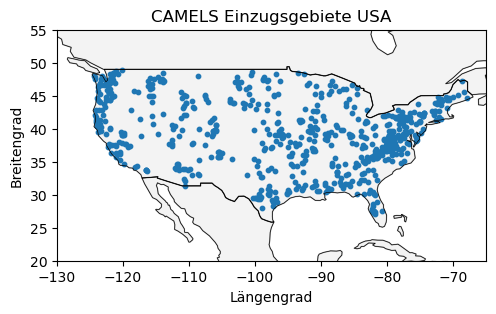

In [4]:
# plot map with catchment locations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.gauge_lon, df.gauge_lat))
fig, ax = plt.subplots(figsize=(6, 3))
world.boundary.plot(ax=ax, linewidth=0.5, color='black')
world.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.25)
gdf.plot(ax=ax, markersize=10, color='tab:blue')
plt.title('CAMELS Einzugsgebiete USA')
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.xlim(-130, -65); plt.ylim(20, 55)
%matplotlib inline

### Wichtigste Variablen

In dieser Vorlesung nutzen wir hauptsächlich die folgenden Variablen. Die englischen Variablennamen sind auch angegeben, da diese häufig erklären, woher die Abkürzungen stammen.

| Name | Englischer Name | Abkürzung |Einheit|
|:-----|:-----|:-----|:-----|
| Niederschlag | Precipitation |  $P$ | mm/y |
| Potentielle Verdunstung | Potential evaporation | $PET$ | mm/y |
| Tatsächliche Verdunstung | Actual evaporation | $AET$ | mm/y |
| Abfluss | Discharge | $Q$ | mm/y |
| Speicheränderung | Storage change | $\Delta S$ | mm/y |
| Nettostrahlung | Net radiation | $R_n$ | W/m² |
| Latente Wärme | Latent heat | $L$ | W/m² |
| Fühlbare Wärme | Sensible heat | $H$ | W/m² |
| Bodenwärmestrom | Ground heat flux | $G$ | W/m² |

# **II. Budyko and die klimatische Wasserbilanz**

Dieser Abschnitt beinhaltet den Kern der Vorlesung, inklusive Hintergrund, Theorie, sowie interaktiver Datenanalyse und Visualisierung.
Im Laufe der Notebooks werden verschiedene <span style="color:Indigo">**Fragen**</span> gestellt, die Sie beantworten sollen um die <span style="color:DarkRed">**Lernziele**</span> zu erreichen.



**Übersicht**

1. Einführung
2. Die klimatische Wasserbilanz 
3. Die Budyko-Kurve
4. Abweichungen von der Budyko-Kurve
5. Die Wasserbilanz für verschiedene Jahre

## **1. Einführung**

<span style="color:DarkRed">**Lernziel**: *Sie sollten die wichtigsten Kenngrößen der klimatischen Wasserbilanz kennen und den Zusammenhang zwischen Wasser- und Energiebilanz erläutern können.*</span>

### **1.1 Mikhail Ivanovich Budyko (20.01.1920 – 10.12.2001)**

In den Jahren 1955-1974 studierte Mikhail Budyko ([Bildquelle](https://en.wikipedia.org/wiki/Mikhail_Budyko#)) im Rahmen seiner Forschungen die Komponenten der Land- und Meeresenergiebilanz, was in Russland und darüber hinaus weithin anerkannt wurde und den Grundstein für einen neuen Bereich der Meteorologie legte - die physikalische Klimatologie (Theorie des Klimas). 

<img src="figures/Mikhail_Ivanovich_Budyko.jpg" alt="drawing" width="200"/>


### **1.2 Die langfristige Wasserbilanz eines Einzugsgebiets**

Die Wasserbilanz eines Einzugsgebiets kann wie folgt beschrieben werden:

\begin{equation}
\tag{1}
P + Q_{in} = AET + Q_{out} + \Delta S \label{water_balance}
\end{equation}

wobei $P$ den Niederschlag beschreibt, $AET$ die tatsächliche Verdunstung, $Q_{in}$ den Zufluss (ober- und unterirdisch), $Q_{out}$ den Abfluss (ober- und unterirdisch) und $\Delta S$ die Speicheränderung (alle in mm/y).

Ein Einzugsgebiet ist definiert als das Gebiet, das zu einem Punkt (z.B. Pegelmessstelle eines Flusses) hin entwässert, primär bedingt durch die Topographie. Dementsprechend hat ein Einzugsgebiet (normalerweise) keine oberirdischen Zuflüsse. Das Wasser, das nicht verdunstet, fließt großteils als Abfluss ($Q$) über ein Fließgewässer ab.

Budyko nimmt nun weiter an, dass in großen Einzugsgebieten ($\gg$1000 km²) unterirdische Zu- und Abflüsse durch das Grundwasser vernachlässigbar sind und dass für lange Zeiträume (30 Jahre und länger) die Änderung des Speichers gegen null geht. 
Die langfristige Wasserbilanz für große Einzugsgebiete ist dann:

\begin{equation}
\tag{2}
P = AET + Q \label{water_balance_Budyko}
\end{equation}

<img src="figures/water_balance.png" alt="drawing" width=250/>

Gleichung (2) nimmt also an, dass sämtliche Wasser-Inputs in ein Einzugsgebiet vom Niederschlag stammen und sämtliche Wasser-Outputs in Form von Verdunstung oder (oberirdischem) Abfluss stattfinden.

### **1.3 Die Energiebilanz an der Landoberfläche**
Die Energiebilanz an der Landoberfläche kann (vereinfacht) wie folgt beschrieben werden:

\begin{equation}
\tag{3}
R_n = L + H + G \label{energy_balance}
\end{equation}

wobei $R_n$ die Nettostrahlung beschreibt, $L$ die latente Wärme, $H$ die fühlbare Wärme und $G$ den Bodenwärmestrom (alle in W/m²).
Die latente Wärme ist die Energie, die für die Verdunstung von Wasser genutzt wird, da der Übergang von flüssigem zu gasförmigem Wasser Energie braucht.

<img src="figures/energy_balance.png" alt="drawing" width=100/>

Die Nettostrahlung liefert also alle Energie, die dann in latente Wärme, fühlbare Wärme oder Bodenwärmestrom umgewandelt wird.


### **1.4 Der Zusammenhang zwischen Wasser- und Energiebilanz**

Die latente Wärme kann auch über die tatsächliche Verdunstung $AET$ ausgedrückt werden:

\begin{equation}
\tag{4}
L = \lambda_w AET \label{latent_heat}
\end{equation}

wobei $\lambda_w$ die Verdunstungsenthalpie ist, also die Menge an Energie, die es braucht um eine bestimmte Menge an Wasser zu verdampfen (diese ist leicht abhängig von der Temperatur $T$). Beispielsweise braucht es ca. 2.45 MJ um einen Liter Wasser zu verdampfen, ungefähr so viel Energie wie in einer Tafel Schokolade.

Der Bodenwärmestrom $G$ ist meistens sehr klein und kann daher vernachlässigt werden, so dass sich folgende Gleichung ergibt:

\begin{equation}
\tag{5}
R_n = \lambda_w AET + H \label{energy_and_water_balance}
\end{equation}

Gleichung (5) verbindet nun also die Wasserbilanz mit der Energiebilanz über die tatsächliche Verdunstung ($AET$), da für diese sowohl Wasser als auch Energie benötigt werden. Gleichung (5) ist somit eine wichtige Grundlage der Hydroklimatologie.

Außerdem definieren wir nun noch die potentielle Verdunstung $PET$. Das ist die Menge an Wasser, die verdunstet werden könnte, wenn immer genügend Wasser vorhanden wäre (z.B. über einem See). 
Diese kann über die Nettostrahlung (die verfügbare Energie) genähert werden:

\begin{equation}
\tag{6}
PET = \frac{R_n}{\lambda_w} \label{potential_evaporation}
\end{equation}

Es gibt auch noch weitere Berechnungsformeln für die potentielle Verdunstung, diese werden allerdings hier nicht behandelt.

Drückt man nun Gleichung (5) mithilfe der potentiellen Verdunstung aus, ergibt sich folgende Gleichung:

\begin{equation}
\tag{7}
PET = AET + \frac{H}{\lambda_w} \label{pet_and_water_balance}
\end{equation}

Die Nettostrahlung bzw. potentielle Verdunstung, die nicht dazu beiträgt Wasser zu verdunsten, wird in fühlbare Wärme umgewandelt.

<span style="color:Indigo">**Einfache Frage**: *Zwei Einzugsgebiete erhalten die gleiche Menge an Niederschlag, jedoch unterschiedliche Mengen an Nettostrahlung. Welches der Einzugsgebiete hat einen höheren Abfluss und wie kann man das erklären?*</span>

<span style="color:Indigo">**Schwere Frage**: *Heutzutage wird häufig vom Konzept "Schwammstadt" gesprochen: es soll mehr Wasser in den Städten zurückgehalten werden. Was für Auswirkungen hat eine Zunahme an verfügbarem Wasser auf die Umwandlung der Nettostrahlung (Gleichung 6) und was hat das für einen Einfluss auf das Stadtklima (z.B. die Temperatur)?*</span>

## **2. Die klimatische Wasserbilanz** 

<span style="color:DarkRed">**Lernziel**: *Sie sollten erklären können, was die klimatische Wasserbilanz ist und wieso die Einteilung von Einzugsgebieten in wasser- und energie-limitiert nützlich ist.*</span>

### **2.1 Der Trockenheitsindex**
Die klimatische Wasserbilanz ist definiert als $P - PET$.
Sie ist eng verwandt mit dem sogenannten Trockenheitsindex $\phi$ (manchmal auch Aridität genannt):

\begin{equation}
\tag{8}
\phi = \frac{PET}{P} \label{aridity_index}
\end{equation}

### **2.2 Energie- und wasser-limitierte Gebiete**
Gebiete, in denen $P$ größer als $PET$ ist (bzw. $\phi < 1$), werden als **energie-limitiert** bezeichnet. 
In energie-limitierten Gebieten kann (fast) alle Energie genutzt werden ($PET \approx AET$) um Wasser zu verdunsten.

Gebiete, in denen $P$ kleiner als $PET$ ist (bzw. $\phi > 1$), werden als **wasser-limitiert** bezeichnet.
In solchen Gebieten kann nicht alle Energie genutzt werden um Wasser zu verdunsten, da nicht genügend Wasser vorhanden ist. 
Die Energie, die nicht genutzt wird um Wasser zu verdunsten, wird in fühlbare Wärme $H$ umgewandelt.


### **2.3 Der Zusammenhang zwischen klimatischer Wasserbilanz und Abfluss**
Der unten stehende Code-Block erzeugt eine Grafik, die den Abfluss in Abhängigkeit der klimatischen Wasserbilanz zeigt. Nutzen Sie bitte die unten gezeigte Grafik um die folgenden Fragen zu beantworten.

<span style="color:Indigo">**Einfache Frage**: *Wo ist der Abfluss höher: in wasser- oder energie-limitierten Gebieten? Woran liegt das?*</span>

<span style="color:Indigo">**Schwere Frage**: *Was ist der niedrigste Wert, den der Abfluss in wasser- bzw. energie-limitierten Gebieten annehmen kann? Woran liegt das?*</span>

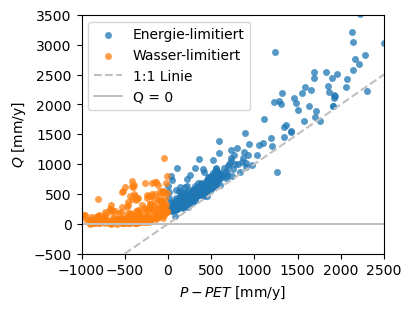

In [5]:
# define function that plots the climatic water balance against streamflow
def plot_climatic_water_balance(*args):
        
    # create figure
    fig = plt.figure(figsize=(4, 3), constrained_layout=True) 
    axes = plt.axes()
    
    # plot climatic water balance against streamflow separated into energy- and water-limited catchments
    # to get annual values we multiply the daily values by 365
    im = axes.scatter(df.loc[df["aridity_class"] == 0, "climatic_water_balance"]*365, 
                      df.loc[df["aridity_class"] == 0, "streamflow"]*365,
                      s=25, c="tab:blue", alpha=0.75, lw=0, label='Energie-limitiert')#, 
    im = axes.scatter(df.loc[df["aridity_class"] == 1, "climatic_water_balance"]*365, 
                      df.loc[df["aridity_class"] == 1, "streamflow"]*365,
                      s=25, c="tab:orange", alpha=0.75, lw=0, label='Wasser-limitiert')#,
    
    # plot 1:1 lineand horizontal line at y=0
    axes.axline((0, 0), slope=1, c='silver', label='1:1 Linie', linestyle='--')
    axes.axhline(c='silver', label='Q = 0')
    
    # specify axes, labels, etc.
    axes.set_xlabel("$P - PET$ [mm/y]")
    axes.set_ylabel("$Q$ [mm/y]")
    axes.set_xlim([-1000, 2500])
    axes.set_ylim([-500, 3500])
    axes.legend(loc='best')
    
    plt.show()
    
# run the function
plot_climatic_water_balance()

%matplotlib inline

## **3. Die Budyko-Kurve**

<span style="color:DarkRed">**Lernziel**: *Sie sollten die Herleitung der Budyko-Kurve erläutern können und erklären können, weshalb manche Einzugsgebiete außerhalb der Limits liegen.*</span>

### **3.1 Das Energie- und das Wasser-Limit als Grundlage von Budykos Theorie**

Wir haben gesehen, dass die Unterteilung in wasser- und energie-limitierte Gebiete erste Rückschlüsse auf die Hydrologie eines Einzugsgebietes zulässt. Budyko hat diese Zusammenhänge nun in großem Maßstab zwischen verschiedenen Gebieten untersucht und dabei theoretische Überlegungen mit Messdaten kombiniert.

In energie-limitierten Gebieten (z.B. feuchte Gebiete wie Schottland oder Schweden) nähert sich die tatsächliche Verdunstung der potentiellen Verdunstung an.

\begin{equation}
%\tag{}
AET \rightarrow PET \label{}
\end{equation}

In wasser-limitierten Gebieten (z.B. trockene Gebiete wie Südspanien oder die Sahara) nähert sich die Verdunstung dem Niederschlag an.

\begin{equation}
%\tag{}
AET \rightarrow P \label{}
\end{equation}

Wir definieren nun neben dem Trockenheitsindex $\phi$ noch den sogenannten Verdunstungsindex $\psi$:

\begin{equation}
\tag{9}
\psi = \frac{AET}{P} \label{evaporative_faction}
\end{equation}

Für zunehmend energie-limitierte ("humide") Gebiete, nähert sich der Verdunstungsindex dem Trockenheitsindex an, da alle Energie für die Verdunstung genutzt wird.
Für zunehmend wasser-limitierte ("aride") Gebiete, nähert sich der Verdunstungsindex 1 an, da der ganze Niederschlag verdunstet.

### **3.2 Budykos ursprüngliche Kurve**
Bildet man den Verdunstungsindex als Funktion des Trockenheitsindex ab, so ist der Verdunstungsindex für humide Gebiete von der vorhandenen Energie limitiert und für aride Gebiete vom vorhandenen Wasser limitiert. 
 
Budyko hat nun den Trockenheitsindex $\phi$ und den Verdunstungsindex $\psi$ von echten Einzugsgebieten geneinander aufgetragen und festgestellt, dass die Einzugsgebiete einer Kurve folgen.
Diese Kurve hat er, basierend auf Ergebnissen früherer Forschungsarbeiten anderer Forschenden, mit der folgenden Formel genähert:

\begin{equation}
\tag{10}
\psi = [\phi \tanh(1/\phi) (1 - \exp(-\phi))]^{1/2} \label{budyko_equation}
\end{equation}

Diese Formel entspricht einer Kurve, die sich dem Energie- bzw. Wasserlimit annähert und gut zu den von Budyko untersuchten Einzugsgebieten passt, ist aber rein empirisch. Die unten gezeigte Grafik zeigt das Energie- bzw. Wasserlimit sowie Budykos Kurve.

<img src="figures/Budyko_curve.png" alt="drawing" width="400"/>

### **3.3 Echte Einzugsgebietsdaten im "Budyko-Raum"**
Nun schauen wir uns das ganze mit echten Daten an. Wir nutzen 671 Einzugsgebiete aus dem CAMELS-Datensatz, der oben vorgestellt wurde.
Da es normalerweise keine direkten Messungen der Verdunstung in einem Einzugsgebiet gibt, nutzen wir Abflussdaten, die wir mithilfe von Gleichung (2) in Verdunstung umrechnen ($AET = P - Q$). Der Verdunstungsindex kann dann als Funktion von $Q$ und $P$ ausgedrückt werden.

\begin{equation}
\tag{11}
\psi = \frac{AET}{P} = \frac{P - Q}{P} = 1 - \frac{Q}{P}  \label{evaporative_fraction_using_Q}
\end{equation}


Der unten angezeigte Plot zeigt, dass die meisten Datenpunkte den von Budyko postulierten Grenzen folgen. Die Kurve passt zwar nicht perfekt, gibt aber den generellen Trend gut wieder. Diese Daten sind unabhängig von den von Budyko verwendeten Daten, was darauf hindeutet, dass die Budyko-Kurve auch auf andere Bereiche übertragbar ist und somit eine allgemeinere Gültigkeit hat. 

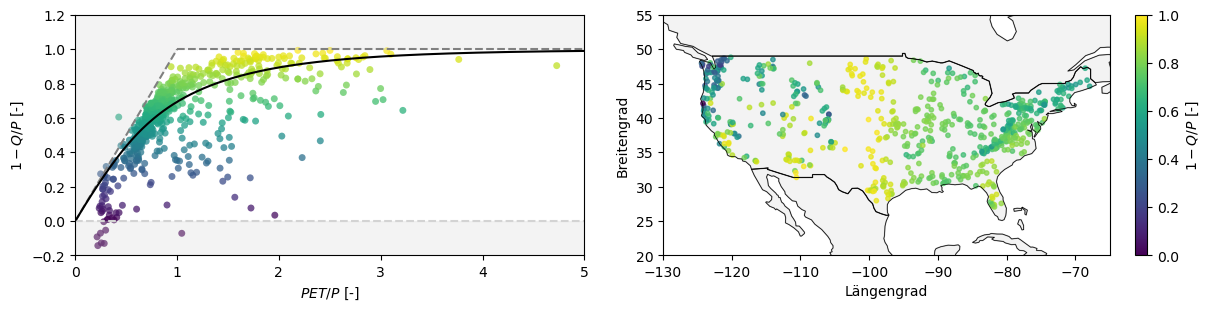

In [6]:
def plot_Budyko(plot_curve=False,*args):
    
    # create figure
    #fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    #axes = plt.axes()
    
    # create figure
    fig, axes = plt.subplots(figsize=(12, 3), constrained_layout=True, 
                             nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 2]})
    
    # plot catchments in Budyko space
    #im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, alpha=0.5, lw=0, c='grey') 
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, alpha=0.75, lw=0, c=1-df["runoff_ratio"], cmap='viridis', vmin=0, vmax=1) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    
    # plot Budyko curve
    if plot_curve == True:
        helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
        
    # plot map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.gauge_lon, df.gauge_lat))
    #fig, ax = plt.subplots(figsize=(6, 3))
    world.boundary.plot(ax=axes[1], linewidth=0.5, color='black')
    world.plot(ax=axes[1], color='lightgrey', edgecolor='black', alpha=0.25)
    plot = gdf.plot(ax=axes[1], markersize=10, column=1-gdf["runoff_ratio"], alpha=0.75, cmap='viridis')
    norm = Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([]) 
    cbar = fig.colorbar(sm, ax=axes[1], orientation='vertical', label='$1 - Q/P$ [-]')
    plt.xlabel('Längengrad')
    plt.ylabel('Breitengrad')
    plt.xlim(-130, -65); plt.ylim(20, 55)

# this function plots catchments in Budyko space as well as the Budyko curve
plot_Budyko(plot_curve=True) 

%matplotlib inline

<span style="color:Indigo">**Frage**: *Manche Einzugsgebiete liegen außerhalb der theoretischen Grenzen (im grauen Bereich). Welche Gründe könnte es dafür geben? Nennen Sie mindestens zwei.*</span>

**Hinweis**: Im folgenden werden wir diese Punkte nicht mehr betrachten, sondern uns auf die Punkte innerhalb der Limits konzentrieren.

In [7]:
# remove points outside limits
df.loc[np.logical_or((1-df["runoff_ratio"])<0,(1-df["runoff_ratio"])>df["aridity"])] = np.nan

## **4. Abweichungen von der Budyko-Kurve**

<span style="color:DarkRed">**Lernziel**: *Sie sollten verschiedene Gründe dafür nennen können, weshalb manche Einzugsgebiete von der Budyko-Kurve abweichen und diskutieren können, welche Gründe für bestimmte Gebiete plausibel sind.*</span>

### **4.1 Quantifizierung der Abweichung**
Wie man sehen kann, liegen nicht alle Einzugsgebiete auf der Budyko-Kurve. Welche Gründe könnte es, abgesehen von Unsicherheiten in den Daten, für eine Abweichung von der Linie geben? Um diese Frage zu beantworten, quantifizieren wir zuerst die Abweichungen von der Kurve. 

Hierzu berechnen wir für jedes Einzugsgebiet den Verdunstungsindex basierend auf Budykos Kurve indem wir den Trockenheitsindex des Einzugsgebiets in Gleichung (8) einsetzen.

Nun können wir den tatsächlichen Verdunstungsindex (genähert als $1 - Q/P$) mit dem berechneten Verdunstungsindex (Gleichung 8) vergleichen. Wir berechnen die Differenz der beiden Werte, die sogenannte Budyko-Anomalie. Je weiter der Wert unterhalb der Kurve ist, desto negativer ist er und je weiter der Wert oberhalb der Kurve ist, desto positiver ist er. Das können Sie in der folgenden Grafik sehen.


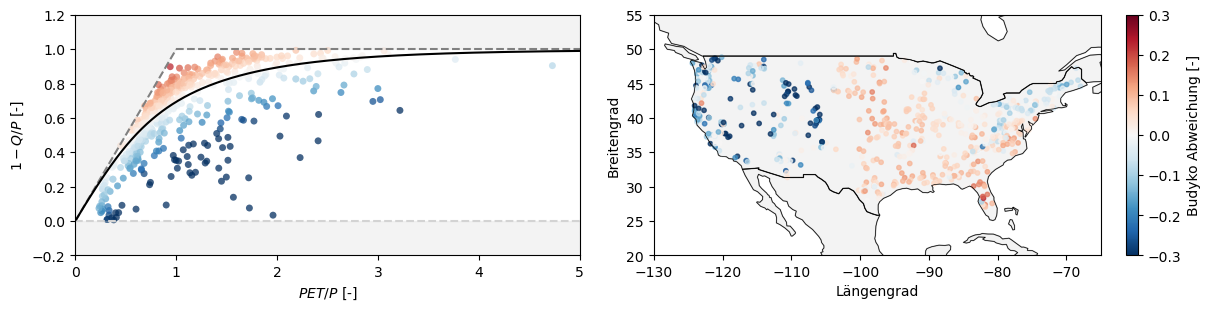

In [8]:
# define function that creates a Budyko plot coloured according to Budyko anomalies
def plot_Budyko_anomaly(*args):
    
    #todo: add dict for z name and unit
    
    # create figure
    #fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    #axes = plt.axes()
    
    # create figure
    fig, axes = plt.subplots(figsize=(12, 3), constrained_layout=True, 
                             nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 2]})
    
    # plot catchments in Budyko space coloured according to Budyko anomalies
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c=df["Budyko_anomaly"], 
                      alpha=0.75, lw=0, cmap='RdBu_r', vmin=-0.3, vmax=0.3) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])   
    #axes.set_xscale('log')
    #cbar = fig.colorbar(im, ax=axes)
    #cbar.set_label("Budyko Abweichung [-]")   
    #cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)
    
    # plot map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.gauge_lon, df.gauge_lat))
    #fig, ax = plt.subplots(figsize=(6, 3))
    world.boundary.plot(ax=axes[1], linewidth=0.5, color='black')
    world.plot(ax=axes[1], color='lightgrey', edgecolor='black', alpha=0.25)
    plot = gdf.plot(ax=axes[1], markersize=10, column=gdf["Budyko_anomaly"], alpha=0.75, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    norm = Normalize(vmin=-0.3, vmax=0.3)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([]) 
    cbar = fig.colorbar(sm, ax=axes[1], orientation='vertical', label='Budyko Abweichung [-]')
    plt.xlabel('Längengrad')
    plt.ylabel('Breitengrad')
    plt.xlim(-130, -65); plt.ylim(20, 55)
    
# run the function
plot_Budyko_anomaly()

%matplotlib inline

### **4.2 Gründe weshalb nicht alle Einzugsgebiete auf einer Kurve liegen**

<span style="color:Indigo">**Frage A**: *Überlegen Sie sich mindestens drei Gründe (Hypothesen) für die Abweichungen von der Budyko-Kurve. Nutzen Sie dazu ein KI-Tool.*</span>

Nutzen Sie ein KI-Tool (künstliche Intelligenz) um Gründe für die Abweichungen von der Budyko-Kurve herauszufinden, wie z.B. https://www.perplexity.ai/ oder https://openai.com/chatgpt. 

Im nächsten Abschnitt können Sie verschiedene Hypothesen zur Erklärung der Abweichungen mit Daten überprüfen.
Um herauszufinden, welche Gründe die Abweichungen verursachen könnten, können wir verschiedene Einzugsgebietseigenschaften nutzen.
Das sind Werte, die bestimmte Eigenschaften eines Einzugsgebiets zusammenfassen; z.B. die durchschnittliche Höhe, der Wald-Anteil, oder der Anteil an Regen, der als Schnee fällt.

<span style="color:Indigo">**Frage B**: *Überprüfen Sie diese Hypothesen aus Frage A mit echten Daten.*</span>

Hier sollen Sie zwei Möglichkeiten nutzen, um die Gründe für Abweichungen von der Budyko-Kurve zu untersuchen. 
Zum einen kann man die Punkte im Budyko-Graph der Einzugsgebietseigenschaft entsprechend einfärben - daran lassen sich oft Muster erkennen.
Zum anderen kann man die Abweichungen von der Budyko-Kurve, wie wir sie vorhin berechnet haben, mit den Einzugsgebietseigenschaften vergleichen. 
Das geht sowohl graphisch als auch über die Korrelation. Diese beschreibt eine Beziehung zwischen zwei Variablen mit einem Wert zwischen -1 und 1.
Werte nahe 1 deuten einen starken Zusammenhang an. Werte nahe -1 deuten einen starken umgekehrter Zusammenhang an. Werte nahe 0 deuten an, dass kein Zusammenhang besteht.

Aber, wie man in jeder Statistikvorlesung lernt: Korrelation ist nicht gleich Kausalität. 
Außerdem quantifiziert die Korrelation nur lineare Zusammenhänge und kann daher bestimmte (kompliziertere) Zusammenhänge nicht identifizieren.
Deswegen sollten Sie sich auch Gedanken machen, welche Nachteile diese Art der Analyse hat und was für Lösungen es geben könnte.

Weitere Informationen finden Sie hier: https://en.wikipedia.org/wiki/Correlation 


<span style="color:Indigo">**Zusatzfrage**: *Was für Vor- und Nachteile haben verschiedene KI-Tools?*</span>

In [22]:
# define function that creates Budyko plot coloured according to catchment attributes
def plot_Budyko_attributes(x):
    
    dict_attributes = {'Pegel-ID': 'gauge_id',
                'Pegel-Name': 'gauge_name',
                'Einzugsgebietsfläche [km²]': 'area_gages2',
                'Saisonalität des Niederschlags [-]': 'p_seasonality',
                'Schnee-Anteil des Niederschlags [-]': 'frac_snow',
                'Häufigkeit niederschlagsreicher Tage [%]': 'high_prec_freq',
                'Wald-Anteil [-]': 'frac_forest',
                'Topographische Steigung [m/km]': 'slope_mean',
                'Topographische Höhe [m]': 'elev_mean',
                'Bodentiefe [m]': 'soil_depth_pelletier',
                'Ton-Anteil im Boden [-]': 'clay_frac',
                'Anteil Carbonatgestein [-]': 'carbonate_rocks_frac',
                'Geologische Durchlässigkeit [m²]': 'geol_permeability'}
    
    dict_explantions = {'Einzugsgebietsfläche [km²]': 'Fläche des (topographischen) Einzugsgebiets.',
              'Saisonalität des Niederschlags [-]': 'Negative (positive) Werte zeigen an, dass mehr Niederschlag im Winter (Sommer) fällt.', 
              'Schnee-Anteil des Niederschlags [-]': 'Der Anteil des Niederschlags, der als Schnee fällt.', 
              'Häufigkeit niederschlagsreicher Tage [%]': 'Die Häufigkeit von niederschlagsreichen Tagen (≥ 5 mal mittlerer Tagesniederschlag).',
              'Wald-Anteil [-]': 'Der Anteil des Einzugsgebiets, der mit Wald bedeckt ist.', 
              'Topographische Steigung [m/km]': 'Die durchschnittliche topographische Steigung im Einzugebiet.', 
              'Topographische Höhe [m]': 'Die durchschnittliche Höhe des Einzugsgebiets (über dem Meeresspiegel).', 
              'Bodentiefe [m]': 'Die durchschnittliche Tiefe des Bodens im Einzugsgebiet [m]', 
              'Ton-Anteil im Boden [-]': 'Der durchschnittliche Anteil an Ton (sehr feinkörniges Sediment) im Boden des Einzugsbiets.', 
              'Anteil Carbonatgestein [-]': 'Der Anteil des Einzugsgebiets, an dem Carbonatgestein vorkommt.',       
              'Geologische Durchlässigkeit [m²]': 'Die Durchschnittliche Durchlässigkeit des Gesteins.'}
    
    print(dict_explantions[x])
    #if x == 'Einzugsgebietsfläche [km²]': # transform area to log values for better visibility
    #    df[dict_attributes[x]] = np.log(df[dict_attributes[x]])
        
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, 
                             nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    # plot catchments in Budyko space coloured according to catchment attribute    
    if x == 'Einzugsgebietsfläche [km²]': # transform area to log values for better visibility
        im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c=df[dict_attributes[x]], alpha=0.75, lw=0, cmap='viridis', norm=LogNorm()) 
    else:
        im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c=df[dict_attributes[x]], alpha=0.75, lw=0, cmap='viridis')
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label(x)    
    
    # calculate correlation
    df_tmp = df.dropna() # remove NaN values temporarily
    r_mat = np.corrcoef(df_tmp[dict_attributes[x]], df_tmp["Budyko_anomaly"])
    r = r_mat[0,1] # extract correlation from correlation matrix
    
    # plot vertical line at x = 0
    axes[1].axhline(c='lightgrey', linestyle='--')
    
    # plot catchment attribute against Budyko anomaly
    im = axes[1].scatter(df[dict_attributes[x]], df["Budyko_anomaly"], s=25, c='black', alpha=0.75, lw=0)   #,c=df["Budyko_anomaly"] cmap=plt.colormaps['RdBu'].reversed()
    axes[1].set_title("Korrelation = " + str(np.round(r,2)))    
    # specify axes, labels, etc.
    axes[1].set_xlabel(x)    
    axes[1].set_ylabel("Budyko Abweichung [-]")
    #axes[1].set_xlim([0, 10000])
    if x == 'Einzugsgebietsfläche [km²]': # transform area to log values for better visibility
        axes[1].set_xscale('log')
    #axes[1].legend(loc='best')
    #cbar = fig.colorbar(im, ax=axes[1])
    #cbar.set_label("Budyko Abweichung [-]")   
    #cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)
    
    plt.show()
    
# run the function
widgets.interact(plot_Budyko_attributes, x=[
                'Einzugsgebietsfläche [km²]',
                'Saisonalität des Niederschlags [-]', 
                'Schnee-Anteil des Niederschlags [-]', 
                'Häufigkeit niederschlagsreicher Tage [%]',
                'Wald-Anteil [-]', 
                'Topographische Steigung [m/km]',
                'Topographische Höhe [m]' , 
                'Ton-Anteil im Boden [-]', 
                'Anteil Carbonatgestein [-]',       
                'Geologische Durchlässigkeit [m²]'], 
                layout={'width': 'max-content'}, disabled=False) 

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('Einzugsgebietsfläche [km²]', 'Saisonalität des Niede…

## **5. Die Wasserbilanz für verschiedene Jahre**

<span style="color:DarkRed">**Lernziel**: *Sie sollten erklären können, wieso sich die Wasserbilanz von Jahr zu Jahr ändert und wieso sich energie- und wasser-limitierte Gebiete unterschiedlich verhalten.*</span>

### **5.1 Kürzere Zeitperioden: Variabilität von Jahr zu Jahr**

<span style="color:Indigo">**Einfache Frage**: *Schaut man sich kürzere Zeitperioden an, z.B. einzelne Jahre, so sind bestimmte Annahmen der Budyko-Kurve nicht mehr gegeben.
Welche Annahmen sind das? Und wie zeichnet sich das in den jährlichen Daten ab?*</span>

<span style="color:Indigo">**Schwere Frage**: *Warum schwankt der Verdunstungsindex bei manchen Einzugsgebieten sehr stark von Jahr zu Jahr und bei anderen nicht?*</span>

In [10]:
# define function that highlights a single catchment in Budyko space and how it changes with time
def plot_Budyko_single_catchment(x):
        
    # create figure
    fig, axes = plt.subplots(figsize=(14, 3), constrained_layout=True, 
                             nrows=1, ncols=3, gridspec_kw={'width_ratios': [2, 1, 2]})
            
    dict_names = {'Pine Creek at Cedar Run, PA': 1548500,
                  'WOLF RIVER AT LANGLADE, WI': 4074950,
                  'SANTA CRUZ C NR SANTA YNEZ CA': 11124500,
                  'BUFFALO FORK AB LAVA CREEK NR MORAN WY': 13011900,
                  'ALSEA RIVER NEAR TIDEWATER, OR': 14306500,
                  'Garcitas Ck nr Inez, TX': 8164600}
    dict_explantions = {'Pine Creek at Cedar Run, PA': 'Energie-limitiertes Einzugsgebiet. https://waterdata.usgs.gov/monitoring-location/01548500/',
                        'WOLF RIVER AT LANGLADE, WI': 'Stabiles Abflussregime aufgrund großer Grundwasserspeicher im Einzugsgebiet. https://waterdata.usgs.gov/monitoring-location/04074950/',
                        'SANTA CRUZ C NR SANTA YNEZ CA': 'Stark wasser-limitiertes Einzugsgebiet. https://waterdata.usgs.gov/monitoring-location/11124500/',
                        'BUFFALO FORK AB LAVA CREEK NR MORAN WY': 'Einzugsgebiet mit hohem Schnee-Anteil. https://waterdata.usgs.gov/monitoring-location/13011900/',
                        'ALSEA RIVER NEAR TIDEWATER, OR': 'Stark energie-limitiertes Einzugsgebiet. https://waterdata.usgs.gov/monitoring-location/14306500/',
                        'Garcitas Ck nr Inez, TX': 'Etwas wasser-limitiertes Einzugsgebiet. https://waterdata.usgs.gov/monitoring-location/08164600/'}

    print(dict_explantions[x])
    
    # select years
    years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
    aridity_tmp = np.zeros(len(years))
    runoff_ratio_tmp = np.zeros(len(years))
    precipitation_tmp = np.zeros(len(years))
    i = 0
    for year in years:
        aridity_tmp[i] = df.loc[df["gauge_id"]==dict_names[x], "aridity"+'_'+year].values[0]
        runoff_ratio_tmp[i] = df.loc[df["gauge_id"]==dict_names[x], "runoff_ratio"+'_'+year].values[0]
        precipitation_tmp[i] = df.loc[df["gauge_id"]==dict_names[x], "precipitation"+'_'+year].values[0]
        #print(df.loc[df["gauge_id"]==dict_names[x], "frac_snow"])
        i = i+1

    # plot catchments in Budyko space and highlight individual catchments
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c="lightgrey", alpha=1, lw=0, label='Alle Einzugsgebiete')
    im = axes[0].scatter(aridity_tmp, 1-runoff_ratio_tmp, marker='d', s=35, c='tab:orange', alpha=1.0, lw=0, label='Jährliche Werte Einzugsgebiet') 
    im = axes[0].scatter(df.loc[df["gauge_id"]==dict_names[x], "aridity"], 1-df.loc[df["gauge_id"]==dict_names[x], "runoff_ratio"], marker='d', s=35, c='black', alpha=1.0, lw=0, label='Mittelwert Einzugsgebiet') 
    #im = axes[0].scatter(aridity_tmp, 1-runoff_ratio_tmp, marker='d', s=35, c=np.array(years).astype(float), alpha=1.0, lw=0) 
    #im = axes[0].plot(aridity_tmp, 1-runoff_ratio_tmp, c='grey', alpha=0.75) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0]) 
    axes[0].legend(loc='best')
    
    # plot time series for individual catchments
    im = axes[1].plot(np.array(years).astype(float), aridity_tmp, c='tab:blue', alpha=0.75, label='PET/P')   
    im = axes[1].plot(np.array(years).astype(float), 1-runoff_ratio_tmp, c='tab:orange', alpha=0.75, label='1-Q/P')   
    
    axes[1].axhline(y=1, c='silver')
    
    # specify axes, labels, etc.
    axes[1].set_xlabel("Jahr")    
    axes[1].set_ylabel("[-]")
    axes[1].legend(loc='best')

    # plot map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.gauge_lon, df.gauge_lat))
    #fig, ax = plt.subplots(figsize=(6, 3))
    world.boundary.plot(ax=axes[2], linewidth=0.5, color='black')
    world.plot(ax=axes[2], color='lightgrey', edgecolor='black', alpha=0.25)
    plot = gdf.plot(ax=axes[2], markersize=10, alpha=1.0, c='lightgrey')
    plot = gdf.loc[df["gauge_id"]==dict_names[x]].plot(ax=axes[2], markersize=20, c='tab:orange', alpha=1.0)
    plt.xlabel('Längengrad')
    plt.ylabel('Breitengrad')
    plt.xlim(-130, -65); plt.ylim(20, 55)
        
# run the function
widgets.interact(plot_Budyko_single_catchment, x=[
                'Pine Creek at Cedar Run, PA', 
                'WOLF RIVER AT LANGLADE, WI',
                'SANTA CRUZ C NR SANTA YNEZ CA',
                'BUFFALO FORK AB LAVA CREEK NR MORAN WY',
                'ALSEA RIVER NEAR TIDEWATER, OR',
                'Garcitas Ck nr Inez, TX'])

%matplotlib inline    

interactive(children=(Dropdown(description='x', options=('Pine Creek at Cedar Run, PA', 'WOLF RIVER AT LANGLAD…

# **III. Lösungsvorschläge und zusätzliche Informationen**


## 1. Einführung

<span style="color:Indigo">**Einfache Frage**: *Zwei Einzugsgebiete erhalten die gleiche Menge an Niederschlag, jedoch unterschiedliche Mengen an Nettostrahlung. Welches der Einzugsgebiete hat einen höheren Abfluss und wie kann man das erklären?*</span>

Eine höhere Nettostrahlung führt zu einer höheren potentiellen Verdunstung. Vor allem wenn genügend Wasser vorhanden ist, führt dies zu einer höheren tatsächlichen Verdunstung und dadurch zu einem geringeren Abflussvolumen. 

<span style="color:Indigo">**Schwere Frage**: *Heutzutage wird häufig vom Konzept "Schwammstadt" gesprochen: es soll mehr Wasser in den Städten zurückgehalten werden. Was für Auswirkungen hat eine Zunahme an verfügbarem Wasser auf die Umwandlung der Nettostrahlung (Gleichung 6) und was hat das für einen Einfluss auf das Stadtklima (z.B. die Temperatur)?*</span>

Ist mehr Wasser verfügbar, so kann mehr Nettostrahlung in latente Wärme umgewandelt werden. Da latente Wärme im Gegensatz zu fühlbarer Wärme die Temperatur nicht erhöht (sondern nur die Luftfeuchtigkeit), bleibt die Temperatur in der Stadt geringer. Ganz besonders sichtbar ist dieser Effekt im Sommer in Wäldern, die häufig deutlich kühler sind als ihre Umgebung, da die Verdunstung, ähnlich wie das menschliche Schwitzen, eine kühlende Wirkung hat.

## 2. Die klimatische Wasserbilanz

<span style="color:Indigo">**Einfache Frage**: *Wo ist der Abfluss höher: in wasser- oder energie-limitierten Gebieten? Woran liegt das?*</span>

Wasser-limitierte Gebiete haben einen geringeren Abfluss als energie-limitierte Gebiete, da dort mehr Niederschlag verdunstet wird und somit nicht zu Abfluss wird.

<span style="color:Indigo">**Schwere Frage**: *Was ist der niedrigste Wert, den der Abfluss in wasser- bzw. energie-limitierten Gebieten annehmen kann? Woran liegt das?*</span>

In wasser-limitierten Gebieten nähert sich der Abfluss oft 0 an, da hier fast der gesamte Niederschlag verdunstet. 
In energie-limitierten Gebieten hingegen nähert sich der Abfluss oft der 1:1-Linie an, d.h. $Q = P - PET$. Hier ist genügend Wasser vorhanden, so dass (fast) alle Energie genutzt wird um Wasser zu verdunsten ($PET \approx AET)$. Es kann allerdings nie mehr tatsächliche als potentielle Verdunstung geben, daher ist der Abfluss in energie-limitierten Gebieten nie kleiner als die klimatische Wasserbilanz.

Der Zusammenhang ist allerdings nie perfekt. Zum einen sind Umweltdaten immer mit Unsicherheit behaftet. Zum anderen gibt es noch weitere Faktoren über die klimatische Wasserbilanz hinaus, die die Abflussbildung beeinflussen (s. unten).

## 3. Die Budyko-Kurve

<span style="color:Indigo">**Frage**: *Manche Einzugsgebiete liegen außerhalb der theoretischen Grenzen (im grauen Bereich). Welche Gründe könnte es dafür geben? Nennen Sie mindestens zwei.*</span>

Gründe dafür können Unsicherheiten in den Daten sein. Beispiel: in den Bergen ist die Niederschlagsmessung schwierig und häufig wird weniger $P$ gemessen als tatsächlich fällt. Das kann dazu führen, dass der gemessene Abfluss größer als der gemessene Niederschlag ist.

In manchen Einzugsgebieten stimmt die Annahme nicht, dass alles Wasser durch den Niederschlag geliefert wird. Beispiel: es strömt Grundwasser zu und liefert zusätzlichen Abfluss (oder Verdunstung).

In manchen Einzugsgebieten verlässt nicht alles Wasser das Einzugsgebiet als Abfluss oder Verdunstung. Beispiel: es strömt Grundwasser unterirdisch ab.

Zusätzlich können menschliche Einflüsse dazu führen, dass die Wasserbilanz beeinträchtigt ist, z.B. Wasserentnahme. Die CAMELS US Daten sind zwar "natürliche" Einzugsgebiete, dennoch kann man menschliche Einflüsse nicht gänzlich ausschließen.


## 4. Abweichungen von der Budyko-Kurve

<span style="color:Indigo">**Frage A**: *Überlegen Sie sich mindestens drei Gründe (Hypothesen) für die Abweichungen von der Budyko-Kurve. Nutzen Sie dazu ein KI-Tool.*</span>

**Prompt**: Überlegen Sie sich fünf Gründe (Hypothesen) für die Abweichungen von der Budykokurve, in Tabellenform als markdown code, kurz

**Antwort von ChatGPT**:

Natürlich, hier sind fünf mögliche Gründe (Hypothesen) dafür, dass hydrologische Einzugsgebiete von der Budyko-Kurve abweichen könnten:

| Nr. | Grund für Abweichung             | Erklärung                                                      |
|-----|----------------------------------|----------------------------------------------------------------|
| 1   | Landnutzungswandel               | Veränderungen in der Landnutzung können den Wasserkreislauf beeinflussen, indem sie Abflussmuster und Evapotranspiration verändern. |
| 2   | Geologische Eigenschaften        | Unterschiede in der geologischen Beschaffenheit können die Wasserspeicherung und -freisetzung beeinflussen, was zu Abweichungen führen kann. |
| 3   | Klimawandel                      | Änderungen im Klima, wie erhöhte Temperaturen oder veränderte Niederschlagsmuster, können die Budyko-Kurve beeinflussen. |
| 4   | Menschliche Eingriffe            | Wassermanagementpraktiken, wie Staudammbau oder Wasserentnahme, können den Wasserkreislauf beeinträchtigen und zu Abweichungen führen. |
| 5   | Topografische Unterschiede       | Verschiedene topografische Merkmale, wie Gebirge oder tiefe Täler, können den Wasserkreislauf in einem Einzugsgebiet beeinflussen. |

Diese Gründe dienen nur als hypothetische Erklärungen und erfordern möglicherweise detailliertere Untersuchungen, um die tatsächlichen Ursachen für Abweichungen von der Budyko-Kurve zu verstehen.

**Prompt**: Überlegen Sie sich fünf Gründe (Hypothesen) für die Abweichungen von der Budykokurve, in Tabellenform als markdown code, kurz

**Antwort von Perplexity.ai**: 

Here is a table in markdown code that lists five reasons (hypotheses) for why some hydrological catchments deviate from the Budyko curve:

| Reason | Description |
| ------ | ----------- |
| Spatial Heterogeneity | Variability in land cover, soil properties, and topography can lead to differences in actual evapotranspiration (AET) and precipitation (P), causing deviations from the Budyko curve[4]. |
| Human Activities | Land use changes, such as deforestation or urbanization, can alter the water balance of a catchment, leading to departures from the Budyko curve[4]. |
| Climate Variability | Anomalous weather patterns, such as prolonged droughts or heavy rainfall events, can cause temporary departures from the Budyko curve[4]. |
| Data Uncertainty | Inaccuracies in the estimation of AET, P, and potential evapotranspiration (PET) can lead to deviations from the Budyko curve, especially in data-scarce environments[3]. |
| Model Assumptions | The Budyko curve is based on several assumptions, such as steady-state conditions and spatial homogeneity, which may not hold true for all catchments, leading to deviations from the curve[4]. |

These reasons are based on the information from the provided search results.

Citations:
[1] https://link.springer.com/article/10.1007/s00506-021-00769-x
[2] https://quizlet.com/593777003/geo121-prufung-hydrologie-begriffe-lernziele-flash-cards/
[3] https://publikationen.bibliothek.kit.edu/1000160933
[4] https://www.uwo.ca/biology/faculty/creed/PDFs/presentations/PRE116.pdf
[5] https://d-nb.info/1244268089/34

<span style="color:Indigo">**Frage B**: *Überprüfen Sie diese Hypothesen aus Frage A mit echten Daten.*</span>

Die Antworten der KI-Tools nennen verschiedene mögliche Gründe für Abweichungen von der Budyko-Kurve. Nicht alle davon lassen sich überprüfen, z.B. die Auswirkungen menschlicher Eingriffe, da es sich bei den vorhandenen Einzugsgebieten um quasi-natürliche Einzugsgebiete handelt. 

Verschiedene Einzugsgebietseigenschaften korrelieren mit den Abweichungen von der Budyko-Kurve.
Besonders hervorzuheben sind die topographische Steigung und Höhe und der Schnee-Anteil. 
Außerdem ist die Saisonalität des Niederschlags noch stark mit den Abweichungen korreliert. 
Es gibt verschiedene Erklärungen für diese Zusammenhänge. 

- Schnee: Einzugsgebiete mit hohem Schnee-Anteil reflektieren Strahlung gut (sie haben eine niedrige Albedo), was dazu führen kann, dass wenig Energie für die Verdunstung übrig bleibt. Dieser Albedo-Effekt ist möglicherweise nicht korrekt berücksichtigt in der Berechnung der potentiellen Verdunstung.

- Topographie: In steilen Einzugsgebieten kann Wasser gut ablaufen und ist somit nicht mehr für die Verdunstung verfügbar, was zu höheren Abflüssen führen kann.

- Saisonalität: In Gebieten, in denen Niederschlag hauptsächlich im Winter fällt, sind Niederschlag und potentielle Verdunstung phasenverschoben. Dadurch kann nicht alle Energie genutzt werden um den Niederschlag zu verdunsten.

Ein Problem dieser einfachen Analyse ist, dass beispielsweise die topographische Steigung und der Schnee-Anteil stark miteinander korreliert sind. Es ist daher ohne weitere Analysen nicht einfach zu entschlüsseln, welche Hypothese stimmt bzw. ob nicht beide zum Teilstim

Kaum Einfluss scheinen Eigenschaften bezüglich der Böden und der Geologie zu haben. Hierfür gibt es verschiedene Gründe. Bei einer großskaligen Analyse überwiegt der Einfluss des Klimas häufig. Unterschiede bezüglich der Böden und Geologie kommen meist eher regional oder auf kürzeren Zeitskalen zur Geltung. Außerdem basieren diese Eigenschaften auf sehr unsicheren Datenbanken und sind stark vereinfacht (Mittelwerte über ein ganzes Einzugsgebiet), was diese häufig nicht besonders informativ macht.

Ein nächster Schritt wäre nun prozess-basierte Erklärungen für die jeweiligen Muster zu suchen, indem man z.B. Gründe dafür sucht, warum Einzugsgebiete mit höherem Schnee-Anteil mehr Abfluss erzeugen.

<span style="color:Indigo">**Zusatzfrage**: *Was für Vor- und Nachteile haben verschiedene KI-Tools?*</span>

ChatGPT gibt keine Quellen an, deswegen ist es nicht möglich nachzuvollziehen, woher die Informationen stammen. Das ist problematisch, weil es einerseits die Originalautor*Innen nicht für ihre Arbeit würdigt, und weil andererseits die Aussagen schwer überprüfbar sind. Deswegen ist es wichtig, nicht alles für bare Münze zu nehmen und die Aussagen von ChatGPT anderweitig zu überprüfen (durch andere Quellen, Datenanalyse wie hier, oder nachdenken). Perplexity.ai gibt Quellen an, allerdings sind nicht alle Quellen begutachtete Fachliteratur. Außerdem ist die Antwort auf Englisch.

Beide KI-Tools geben Antworten, die teilweise richtig sind. Allerdings wird beispielsweise Schnee nicht erwähnt, obwohl er eine große Rolle zu spielen scheint. Vieles ist zudem etwas schwammig formuliert und nicht alle Antworten sind richtig bzw. sinnvoll. Bei spezifischen Themen stoßen KI-Tools schnell an ihre Grenzen, da es einerseits nicht immer klare Antworten auf alle wissenschaftlichen Fragen gibt und andererseits eine detaillierte Analyse der Fachliteratur notwendig wäre.


## 5. Die Wasserbilanz für verschiedene Jahre

<span style="color:Indigo">**Einfache Frage**: *Schaut man sich kürzere Zeitperioden an, z.B. einzelne Jahre, so sind bestimmte Annahmen der Budyko-Kurve nicht mehr gegeben.
Welche Annahmen sind das? Und wie zeichnet sich das in den jährlichen Daten ab?*</span>

Schaut man sich langjährige Mittelwerte an, z.B. über 30 Jahre ("klimatologisches Mittel"), so wird es wahrscheinlicher, dass die Speicheränderung im Einzugsgebiet tatsächlich gegen null geht. In einzelnen Jahren kann diese Änderung hingehen sehr groß sein und damit zu Abweichungen von der Budykokurve führen. Man sieht dies gut an den Beispieldaten. Das langjährige Mittel liegt häufig recht nah an der Budyko-Kurve, wohingegen die jährlichen Mittelwerte verstreut sind und meistens stärker von der Kurve abweichen. 

<span style="color:Indigo">**Schwere Frage**: *Warum schwankt der Verdunstungsindex bei manchen Einzugsgebieten sehr stark von Jahr zu Jahr und bei anderen nicht?*</span>

In ständig wasser-limitierten Gebieten (z.B. SANTA CRUZ C NR SANTA YNEZ CA) wird in jedem Jahr fast der gesamte Niederschlag verdunstet, die Verdunstungsindex ist fast immer nahe bei 1, unabhängig davon wie hoch der Trockenheitsindex ist. Das zeigt deutlich auf, dass ein Einzugsgebiet wasser-limitiert ist. 

In ständig energie-limitierten Gebieten (z.B. Pine Creek at Cedar Run, PA oder ALSEA RIVER NEAR TIDEWATER, OR) wird der Verdunstungsindex durch den Trockenheitsindex limitiert. Es kann nie mehr verdunstet werden als Energie zur Verfügung steht. Allerdings wird nicht alle Energie genutzt (d.h. $1 - Q/P < PET/P$). Grund dafür ist z.B. die Saisonalität des Niederschlags und der potentiellen Verdunstung. Die potentielle Verdunstung ist im Sommer am höchsten, häufig ist der Sommer jedoch trockener als der Winter - Niederschlag und Verdunstung sind also phasenverschoben. Dies hat zur Folge, dass nicht aller Niederschlag verdunstet werden kann, selbst wenn im Jahresmittel genügend Energie zur Verfügung steht.

In Einzugsgebieten, die von Jahr zu Jahr von wasser- zu energie-limitiert wechseln (z.B. Garcitas Ck nr Inez, TX), kann man erkennen, dass in stark wasser-limitierten Jahren der Verdunstungsindex nahe 1 ist, wohingegen er in energie-limitierten Jahren vom Trockenheitsindex begrenzt wird und kleiner als 1 ist.

Es gibt aber auch andere Einzugsgebietseigenschaften, die das Verhalten von Jahr zu Jahr beeinflussen können. WOLF RIVER AT LANGLADE, WI ist z.B. ein Fluss, der hauptsächlich von ergiebigen Grundwasserleitern gespeist wird. Diese stabilisieren den Abfluss von Jahr zu Jahr wie ein natürliches Reservoir. Die Folge davon ist, dass die jährlichen Schwankungen im Niederschlag gepuffert werden und Abfluss sowie Verdunstung recht konstant bleiben.

Manche Einzugsgebiete verhalten sich auch gänzlich anders, z.B BUFFALO FORK AB LAVA CREEK NR MORAN WY in dem ca. 70% des Niederschlags als Schnee fallen. Schnee kann die Wasser- und Energiebilanz stark beeinflussen (z.B. durch Reflektion von eingehender Strahlung), ein Thema das immer noch erforscht wird und im Bezug auf den Klimawandel von ernormer Bedeutung ist.
